In [1]:
import sys

sys.path.append("../")

In [2]:
from src.datasets.registry import get_dataset
from src.datasets.common import BaseDataset
from pathlib import Path
from src.utils import download_and_extract_dataset

In [ ]:
DATASET_NAMES = ["CHAOS", "MMWHS"]
DOMAINS = ["CT", "MR"]
DATA_PATH = "../data/"
CHECKPOINT_PATH = "../checkpoints/"
USE_3D = False
TRAINING_EPOCHS = {
    ("CHAOS", "CT"): 1,
}
BATCH_SIZE = 8
SPATIAL_SIZE = 128
LEARNING_RATE = 5e-4
WEIGHT_DECAY = 1e-4

# Set True to enable debug prints/timers/visualizations)
DEBUG = True

In [4]:
CACHE_MAX_ITEMS = 32  # set the in-memory file cache size per dataset (images and segs)
ENABLE_CACHE = True  # set to False to disable caching entirely

In [5]:
CHECKPOINT_PATH = Path(CHECKPOINT_PATH)
DATA_PATH = Path(DATA_PATH)
CHECKPOINT_PATH.mkdir(parents=True, exist_ok=True)

if USE_3D:
    encoder_type = "swin_unetr"
else:
    encoder_type = "clipseg"

In [6]:
import torch
from monai import transforms


# Normalization stats (mean, std) per dataset/domain
NORM_STATS = {
    ("MMWHS", "MR"): (186.5875, 258.5917),
    ("MMWHS", "CT"): (-745.0086, 1042.7251),
    ("CHAOS", "MR"): (90.8292, 168.8922),
    ("CHAOS", "CT"): (-478.1732, 476.7163),
}

# Optimized preprocessing: resize early


def get_preprocessing(dataset_name: str, domain: str, is_training=True):
    decode_func = get_decode_func(dataset_name, domain)
    mean_std = NORM_STATS.get((dataset_name, domain))
    mean, std = mean_std if mean_std is not None else (None, None)

    # Image-specific transforms
    if USE_3D:
        image_transforms = [
            transforms.EnsureChannelFirst(channel_dim="no_channel"),
            transforms.Orientation(axcodes="RAS"),
        ]
    else:
        image_transforms = [
            transforms.Lambda(lambda x: x.squeeze(-1)),
            transforms.EnsureChannelFirst(channel_dim="no_channel"),
        ]

    # Resize early to reduce compute
    image_transforms.append(
        transforms.Resize(
            spatial_size=SPATIAL_SIZE,
            size_mode="longest",
            mode="area",
            anti_aliasing=True,
        )
    )

    # Convert to tensor and ensure float32 for stable CPU ops
    image_transforms.extend(
        [
            transforms.ToTensor(),
            transforms.EnsureType(dtype=torch.float32),
        ]
    )

    # Augmentations (training only) — run in float32 on CPU
    if is_training:
        image_transforms.extend(
            [
                transforms.RandGaussianNoise(prob=0.15, std=0.05),
                transforms.RandAdjustContrast(prob=0.15, gamma=(0.95, 1.05)),
            ]
        )

    # Normalize (still in float32)
    if mean is not None and std is not None:
        image_transforms.append(
            transforms.NormalizeIntensity(
                subtrahend=float(mean),
                divisor=float(std),
                channel_wise=False,
            )
        )

    # Repeat to 3 channels only at the end (2D only)
    if not USE_3D:
        image_transforms.append(transforms.RepeatChannel(repeats=3))

    image_transform = transforms.Compose(image_transforms)

    # Segmentation transforms
    if not USE_3D:
        seg_transforms = [
            transforms.Lambda(lambda x: x.squeeze(-1)),
            transforms.EnsureChannelFirst(channel_dim="no_channel"),
        ]
    else:
        seg_transforms = [
            transforms.EnsureChannelFirst(channel_dim="no_channel"),
            transforms.Orientation(axcodes="RAS"),
        ]

    seg_transforms.extend(
        [
            transforms.ToTensor(),
            transforms.EnsureType(dtype=torch.float32),
            transforms.Lambda(
                lambda x: decode_func(x)
            ),  # decode after tensor conversion
            transforms.Resize(
                spatial_size=SPATIAL_SIZE, size_mode="longest", mode="nearest"
            ),
            transforms.EnsureType(dtype=torch.float32),
        ]
    )

    seg_transform = transforms.Compose(seg_transforms)
    return image_transform, seg_transform


def get_decode_func(dataset_name, domain):
    from src.datasets.mmwhs import mmwhs_labels

    decode = None
    if dataset_name == "CHAOS":
        if domain in ["MR", "MRI"]:

            def decode(labels):
                # Convert intensity values to class indices (keep as float32)
                return labels // 63

        elif domain == "CT":

            def decode(labels):
                return torch.where(labels > 0, 1.0, 0.0)

    elif dataset_name == "MMWHS":

        def decode(labels):
            decoded_labels = torch.zeros_like(labels, dtype=torch.float32)
            for i, label_val in enumerate(mmwhs_labels.keys()):
                decoded_labels[labels == label_val] = i
            return decoded_labels

    if decode is None:

        def decode(labels):
            return labels

    return decode

In [7]:
def print_grad_status(model):
    trainable = []
    frozen = []
    for name, p in model.named_parameters():
        if p.requires_grad:
            trainable.append(name)
        else:
            frozen.append(name)
    print(f"\n=== Parameters requiring grad: {len(trainable)} ===")
    # for n in trainable:
    #     print(f"  + {n}")
    print(f"\n=== Parameters frozen (no grad): {len(frozen)}===")
    # for n in frozen:
    #     print(f"  - {n}")

    return trainable, frozen

In [8]:
def flip_grad_status(model):
    for p in model.parameters():
        p.requires_grad_(not p.requires_grad)

In [9]:
# Helpers to snapshot parameters and report unchanged ones after finetuning
import torch


def snapshot_parameters(model):
    """Return a CPU snapshot of all parameter tensors by name."""
    return {name: p.detach().clone().cpu() for name, p in model.named_parameters()}


def print_unchanged_parameters(model, snapshot, only_requires_grad: bool = True):
    """Print all parameter names whose values are identical to the snapshot.

    Args:
        model: The model to compare.
        snapshot: Dict[name -> Tensor] with the pre-finetune parameter values.
        only_requires_grad: If True, only consider parameters with requires_grad=True.
    """
    unchanged = []
    considered = 0
    for name, p in model.named_parameters():
        if only_requires_grad and not p.requires_grad:
            continue
        prev = snapshot.get(name)
        if prev is None:
            continue
        curr = p.detach().cpu()
        considered += 1
        if torch.equal(curr, prev):
            unchanged.append(name)

    print("\n=== Parameters unchanged after finetuning ===")
    for n in unchanged:
        print(f"  - {n}")
    print(f"Total unchanged: {len(unchanged)} of {considered} considered")

Finetuning on CHAOS dataset in CT domain with 2d images 
Found explicit background class in input. Treating it separately.
Non-background classes: ['Liver']
🔄 Loading CLIPSeg weights...

=== Parameters requiring grad: 72 ===

=== Parameters frozen (no grad): 280===
🚀 Starting training for 3 epochs
   Device: cpu

📖 Epoch 1/3


Training: 100%|██████████| 251/251 [03:55<00:00,  1.07it/s, Loss=0.4130]


Epoch 1 - Train Loss: 0.7066


Validating:   0%|          | 0/54 [00:00<?, ?it/s]

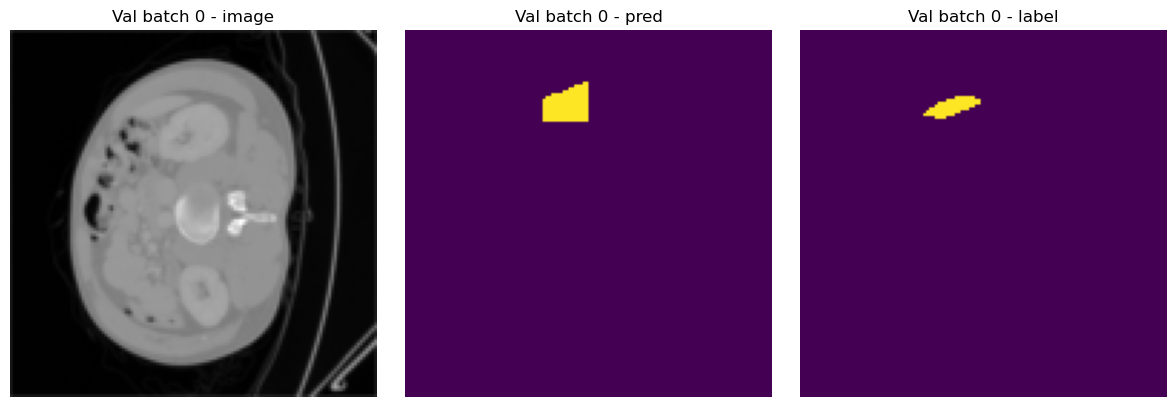

Validating:   2%|▏         | 1/54 [00:00<00:32,  1.65it/s]

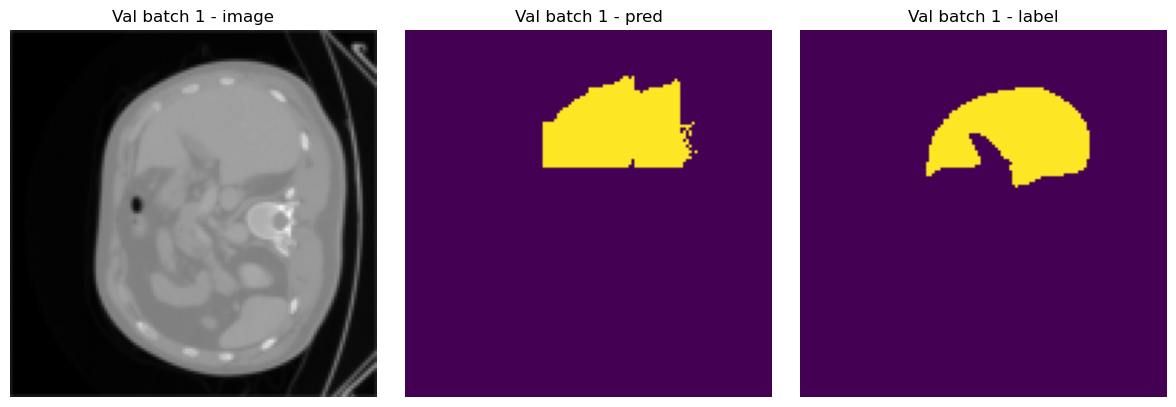

Validating:   4%|▎         | 2/54 [00:01<00:31,  1.64it/s]

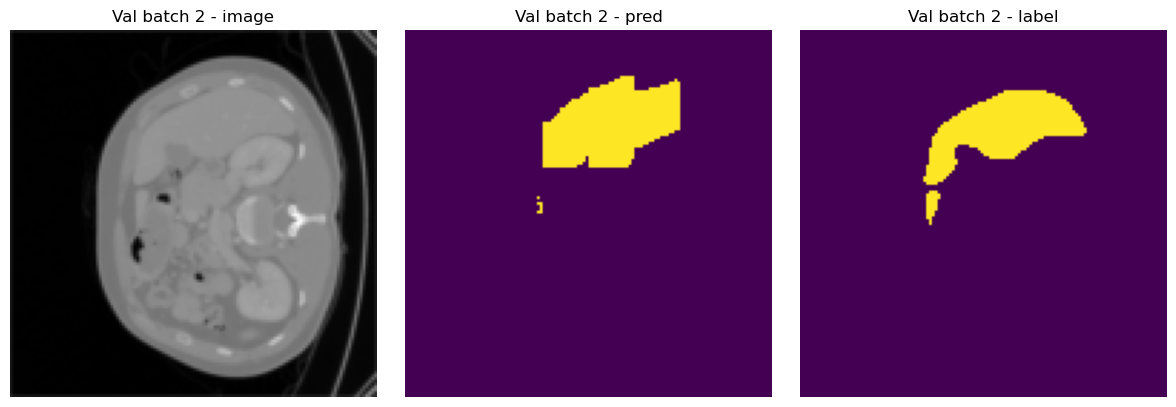

Validating:   6%|▌         | 3/54 [00:01<00:31,  1.62it/s]

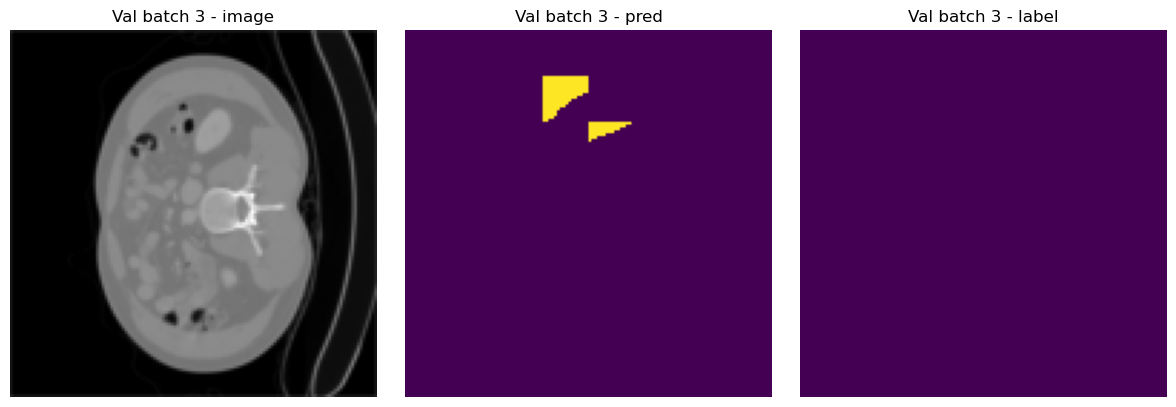

Validating:   7%|▋         | 4/54 [00:02<00:33,  1.51it/s]


Epoch 1 - Val Loss: 0.4375
   New best Val Loss: 0.4375

📖 Epoch 2/3


Training: 100%|██████████| 251/251 [03:58<00:00,  1.05it/s, Loss=0.3775]


Epoch 2 - Train Loss: 0.4130


Validating:   0%|          | 0/54 [00:00<?, ?it/s]

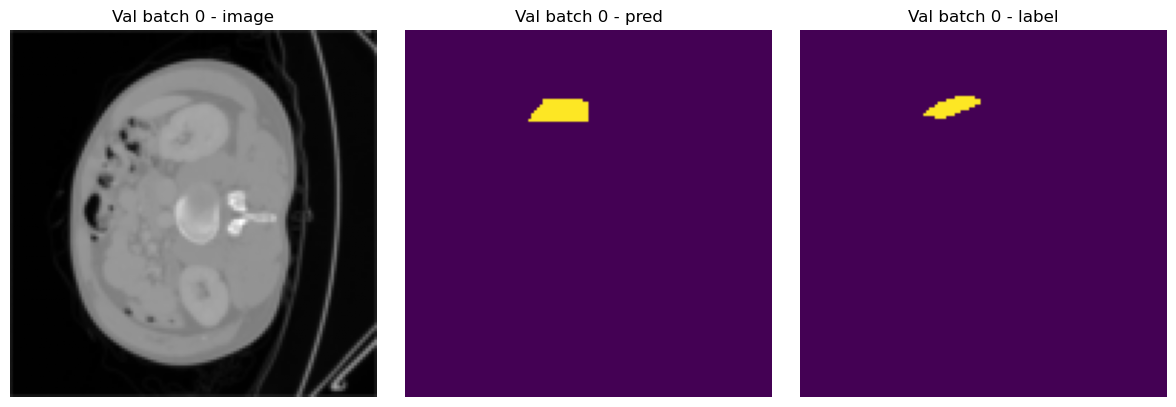

Validating:   2%|▏         | 1/54 [00:00<00:35,  1.49it/s]

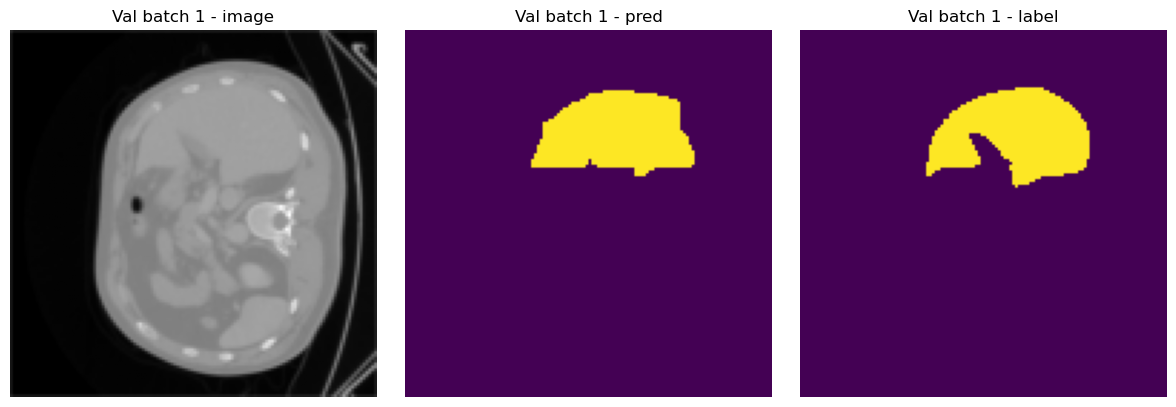

Validating:   4%|▎         | 2/54 [00:01<00:36,  1.41it/s]

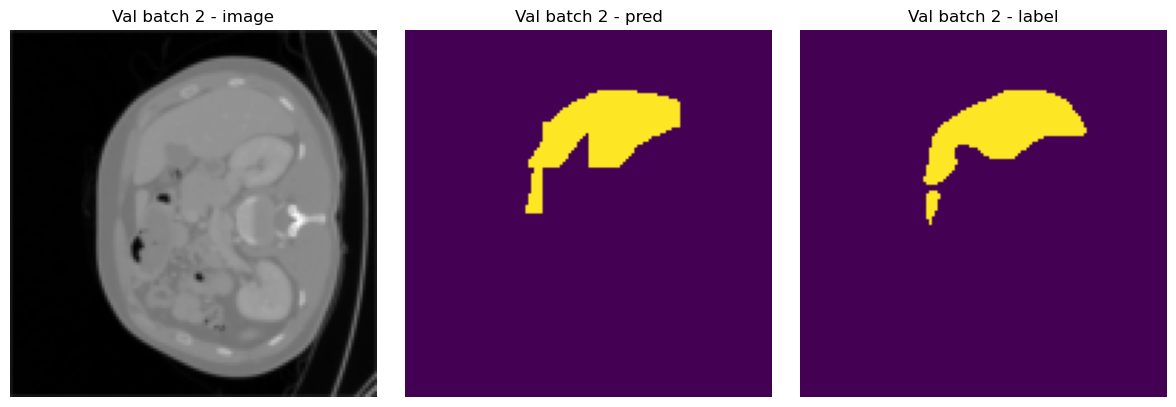

Validating:   6%|▌         | 3/54 [00:02<00:35,  1.44it/s]

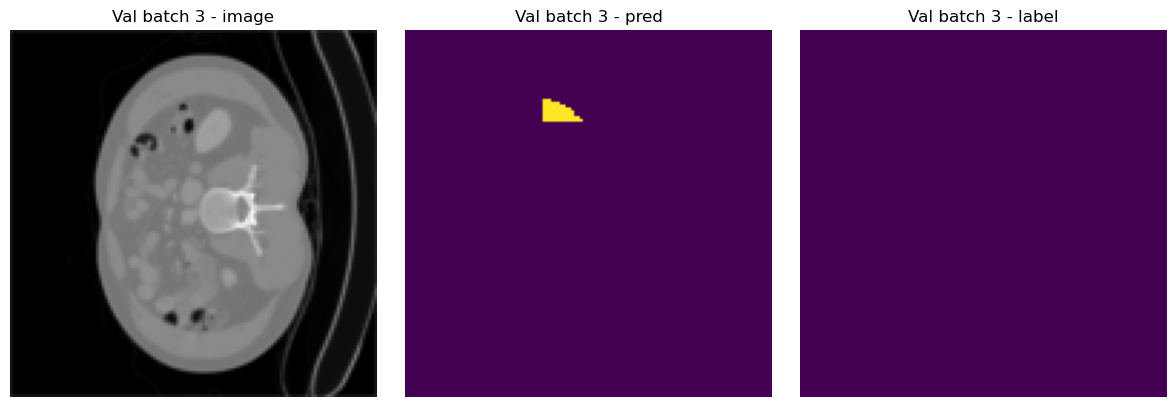

Validating:   7%|▋         | 4/54 [00:03<00:40,  1.22it/s]


Epoch 2 - Val Loss: 0.3366
   New best Val Loss: 0.3366

📖 Epoch 3/3


Training: 100%|██████████| 251/251 [04:30<00:00,  1.08s/it, Loss=0.4223]


Epoch 3 - Train Loss: 0.3659


Validating:   0%|          | 0/54 [00:00<?, ?it/s]

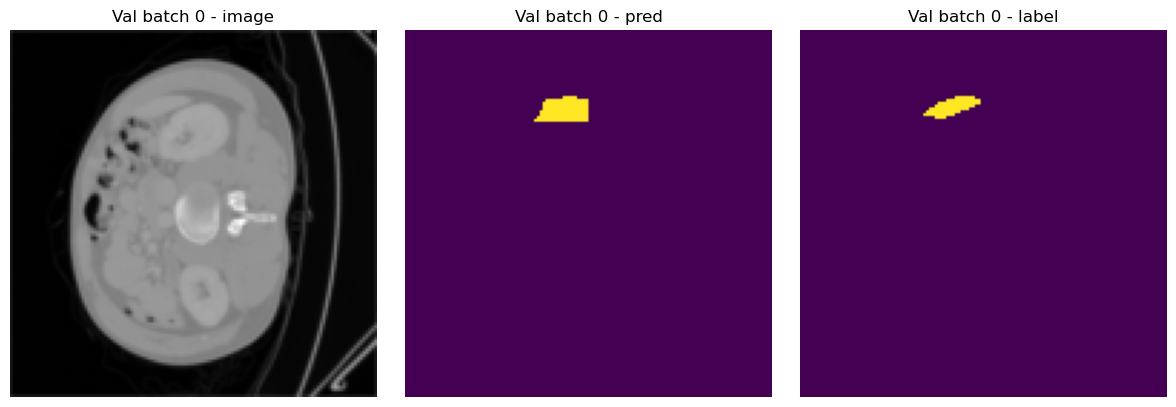

Validating:   2%|▏         | 1/54 [00:00<00:29,  1.80it/s]

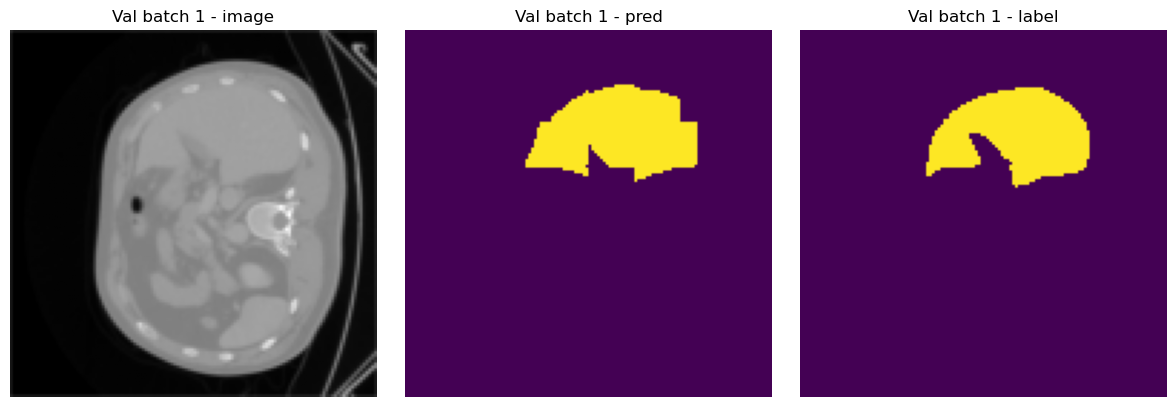

Validating:   4%|▎         | 2/54 [00:01<00:31,  1.67it/s]

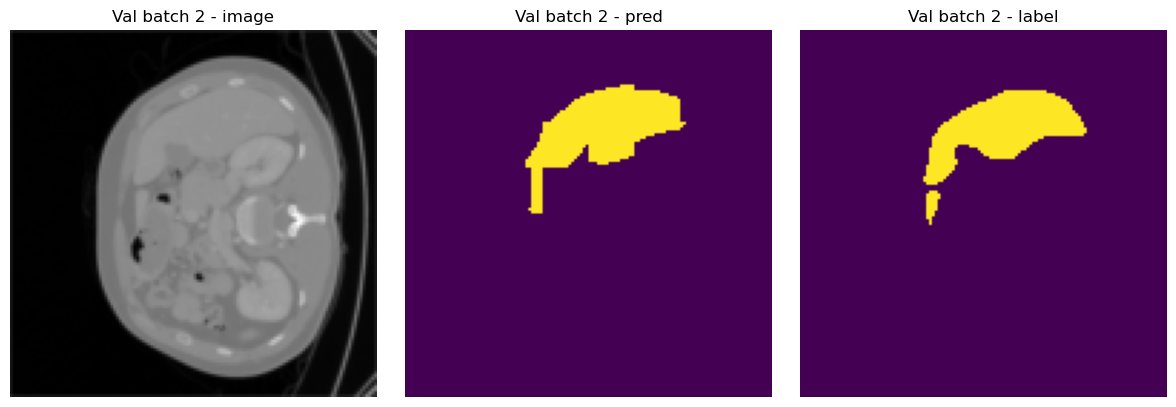

Validating:   6%|▌         | 3/54 [00:01<00:29,  1.72it/s]

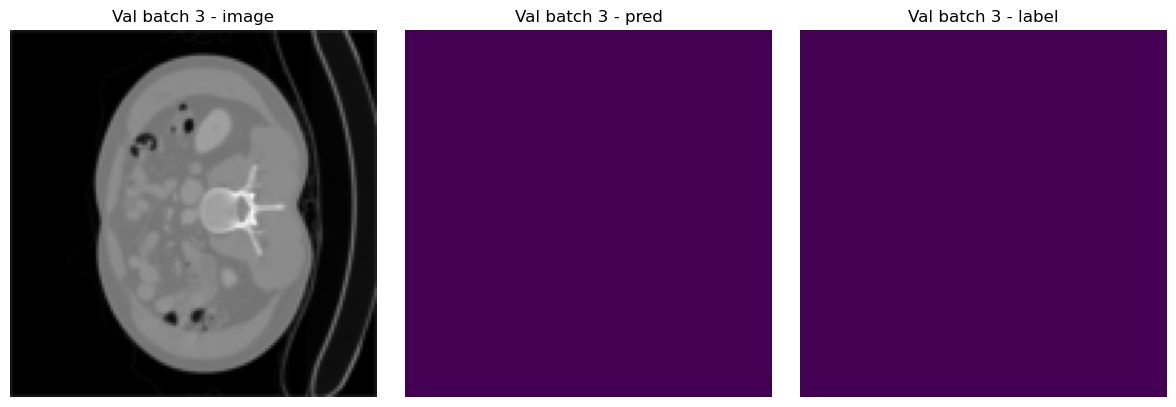

Validating:   7%|▋         | 4/54 [00:02<00:31,  1.61it/s]


Epoch 3 - Val Loss: 0.3128
   New best Val Loss: 0.3128

✅ Training completed!

=== Parameters unchanged after finetuning ===
Total unchanged: 0 of 72 considered


In [ ]:
# Finetuning loop

for (dataset_name, domain), epochs in TRAINING_EPOCHS.items():
    download_and_extract_dataset(dataset_name, DATA_PATH)

    image_transform, seg_transform = get_preprocessing(
        dataset_name, domain, is_training=True
    )

    print(
        f"Finetuning on {dataset_name} dataset in {domain} domain with {'3d' if USE_3D else '2d'} images "
    )
    dataset: BaseDataset = get_dataset(
        dataset_name=dataset_name,
        domain=domain,
        transform=image_transform,  # Use transform instead of preprocess
        seg_transform=seg_transform,  # Pass seg_transform too
        base_path=DATA_PATH,
        batch_size=BATCH_SIZE,
        num_workers=0,
        slice_2d=not USE_3D,
        # new cache knobs
        cache_max_items=CACHE_MAX_ITEMS,
        enable_cache=ENABLE_CACHE,
    )

    #  Ensure the dataset is loaded correctly
    if not isinstance(dataset, BaseDataset):
        raise TypeError(
            f"Expected dataset to be an instance of BaseDataset, got {type(dataset)}"
        )

    model = dataset.get_model(
        encoder_type=encoder_type,
    )

    # Train Only Segmentation Head
    # pass

    # Train Visual Encoder + Segmentation head
    # model.unfreeze()
    # model.freeze_text_encoder()

    # Train Last 2 ResBlocks of Visual Encoder + Segmentation head
    for p in model.encoder.clipseg.reduce.parameters():  # Not in forward pass anyway
        p.requires_grad = False
    for i in range(8, 10):
        for p in model.encoder.clipseg.clip_model.visual.transformer.resblocks[
            i
        ].parameters():
            p.requires_grad = True

    # Train Only Visual Encoder
    # for p in model.encoder.clipseg.model.parameters():
    #     p.requires_grad_(not p.requires_grad)
    # model.freeze_text_encoder()

    # Print grad status before finetuning (after final freeze mask)
    print_grad_status(model)

    # Snapshot parameters before finetuning (after setting requires_grad correctly)
    before_snapshot = snapshot_parameters(model)

    history = model.finetune(
        epochs=3,
        learning_rate=LEARNING_RATE,
        weight_decay=WEIGHT_DECAY,
        val_max_batches=4,
        debug=DEBUG,
        visualize_batches=True,
    )

    # Print parameters that didn't change after finetuning (only those requiring grad)
    print_unchanged_parameters(model, before_snapshot, only_requires_grad=True)